In [1]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from task_ import noise
from PIL import Image
from numba import njit, jit
import numpy as np
import cv2 as cv

%matplotlib inline

print("Setup complete")

Setup complete


In [2]:
def save_noised_img(img: np.ndarray, img_name: str):
    norm_noised = noise.norm_noise_color(np.copy(img), 0, 20, .1)
    sp_noised = noise.sp_noise_color(np.copy(img), .07)

    return [norm_noised, sp_noised]

In [3]:
def pad_img(img: np.ndarray, pad_size: int) -> np.ndarray:
    pading_img = np.pad(img, ((pad_size, pad_size), 
                              (pad_size, pad_size), 
                              (0, 0)), 
                        mode='edge')
    return pading_img.astype('uint8')

In [4]:
# @njit(nogil=True)
def box_average(img: np.ndarray, kernel_size: int) -> np.ndarray:
    pading_value = int(kernel_size/2)
    pading_img = pad_img(img, pading_value)
    result_img = np.ndarray(img.shape)

    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            for k in range(img.shape[2]):
                result_img[x, y][k] = int(np.vdot(pading_img[x : x + kernel_size, y : y + kernel_size, k], 
                                                  np.ones((kernel_size, kernel_size))) / np.power(kernel_size, 2))
    return (result_img % 256).astype('uint8')

In [5]:
# @njit(nogil=True)
def median(img: np.ndarray, kernel_size: int) -> np.ndarray:
    pading_value = int(kernel_size/2)
    pading_img = pad_img(img, pading_value)

    result_img = np.ndarray(img.shape)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            for k in range(img.shape[2]):
                if (img[x, y] == [255, 255, 255]).all() or (img[x, y] == [0, 0, 0]).all():
                    result_img[x, y][k] = np.sort(pading_img[x : x + kernel_size, y : y + kernel_size, k].reshape(np.power(kernel_size, 2)))[int(kernel_size/2)]
                else:
                    result_img[x, y][k] = img[x, y][k]

    return (result_img % 256).astype('uint8')

In [6]:
def gs_kernel(kernel_size: int) -> np.ndarray:
    gaus_smoothing_kernel = np.empty((kernel_size, kernel_size))
    for x in range(kernel_size):
        for y in range(kernel_size):
            gaus_smoothing_kernel = (1 / (np.pi * 2)) * np.exp(-1 * (abs(x - y) ** 2) / 2)
    return gaus_smoothing_kernel

In [7]:
def wieghted_median(img: np.ndarray, kernel_size: int) -> np.ndarray:
    pading_value = int(kernel_size/2)
    pading_img = pad_img(img, pading_value)

    result_img = np.ndarray(img.shape)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            for k in range(img.shape[2]):
                if (img[x, y] == [255, 255, 255]).all() or (img[x, y] == [0, 0, 0]).all():
                    kernel = gs_kernel(kernel_size)
                    window_kernel = np.sort(np.multiply(pading_img[x : x + kernel_size, y : y + kernel_size, k], kernel).reshape(np.power(kernel_size, 2)))
                    result_img[x, y][k] = window_kernel[int(kernel_size/2)]
                else:
                    result_img[x, y][k] = img[x, y][k]

    return (result_img % 255).astype('uint8')

In [8]:
img_monkey = cv.imread("my_org_img/monkey.jpg")
img_arnold = cv.imread("my_org_img/arnold.jpg")
img_rohan = cv.imread("my_org_img/rohan.jpg")

Text(0.5, 1.0, 'Weighted median')

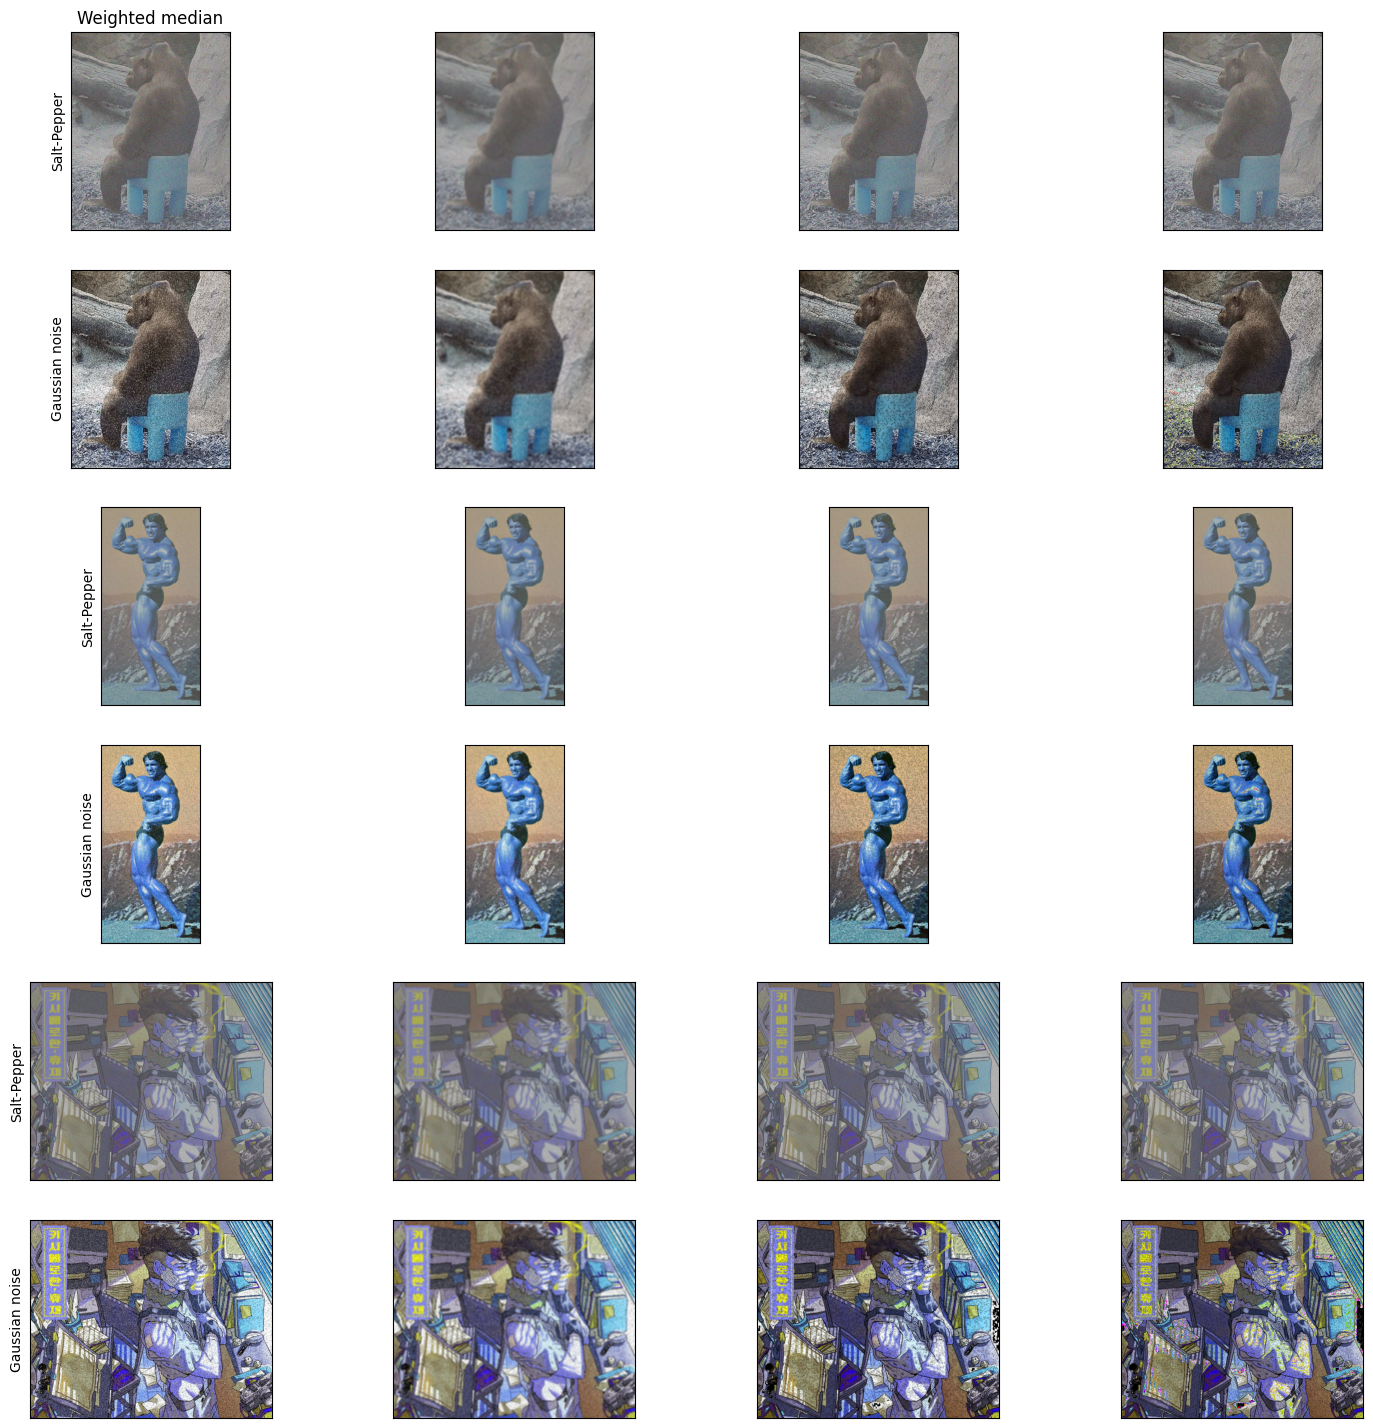

In [9]:
n, sp = save_noised_img(img_monkey, "monkey")
img_dict = {
    "monkey": img_monkey,
    "arnold": img_arnold,
    "rohan": img_rohan
}

fig, axes = plt.subplots(6, 4, figsize=(18, 18))

for i in range(0, 6, 2):
    img_name = list(img_dict)[int(i/2)]
    img = img_dict[img_name]
    n, sp = save_noised_img(img, img_name)
    axes[i, 0].imshow(n)
    axes[i+1, 0].imshow(sp)
    axes[i, 1].imshow(box_average(n, 9))
    axes[i+1, 1].imshow(box_average(sp, 9))
    axes[i, 2].imshow(median(n, 9))
    axes[i+1, 2].imshow(median(sp, 9))
    axes[i, 3].imshow(wieghted_median(n, 9))
    axes[i+1, 3].imshow(wieghted_median(sp, 9))


for i in range(6):
    for j in range(4):
        axes[i, j].xaxis.set_major_locator(ticker.NullLocator())
        axes[i, j].yaxis.set_major_locator(ticker.NullLocator())

for i in range(0, 6, 2):
    axes[i,0].set_ylabel("Salt-Pepper")
    axes[i+1,0].set_ylabel("Gaussian noise")

axes[0, 0].set_title("Noise")
axes[0, 0].set_title("Box average")
axes[0, 0].set_title("Median")
axes[0, 0].set_title("Weighted median")

**Висновок**: з'являються смурфики 

Спробуємо в HSV

In [10]:
hsv_monkey = cv.cvtColor(img_monkey, cv.COLOR_BGR2HSV)
hsv_arnold = cv.cvtColor(img_arnold, cv.COLOR_BGR2HSV)
hsv_rohan = cv.cvtColor(img_rohan, cv.COLOR_BGR2HSV)

In [11]:
def hsv_wieghted_median(img: np.ndarray, kernel_size: int) -> np.ndarray:
    pading_value = int(kernel_size/2)
    pading_img = pad_img(img, pading_value)

    result_img = np.copy(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            # for k in range(img.shape[2]):
                # if (img[x, y] == [255, 255, 255]).all() or (img[x, y] == [0, 0, 0]).all():
            kernel = gs_kernel(kernel_size)
            window_kernel = np.sort(np.multiply(pading_img[x : x + kernel_size, y : y + kernel_size, 0], kernel).reshape(np.power(kernel_size, 2)))
            result_img[x, y][0] = window_kernel[int(kernel_size/2)]
                # else:
                #     result_img[x, y][k] = img[x, y][k]

    return result_img.astype('uint8')

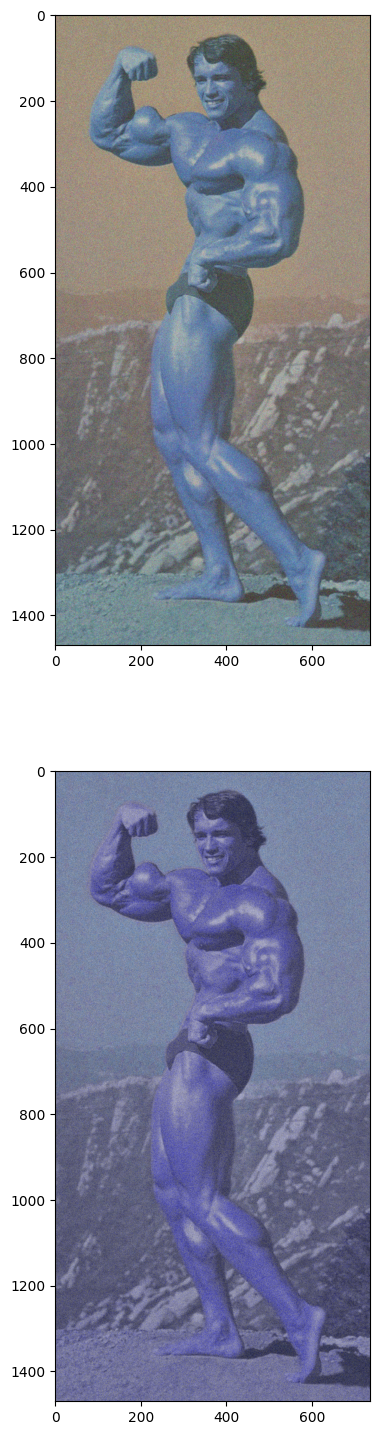

In [12]:
n, sp = save_noised_img(img_arnold, "arnold")
n = cv.cvtColor(n, cv.COLOR_BGR2HSV)
sp = cv.cvtColor(sp, cv.COLOR_BGR2HSV)

fig, axes = plt.subplots(2, 1, figsize=(18, 18))

axes[0].imshow(cv.cvtColor(n, cv.COLOR_HSV2BGR))
axes[1].imshow(cv.cvtColor(hsv_wieghted_median(n, 9), cv.COLOR_HSV2BGR))